In [2]:
import os
from pytorch_lightning import loggers as pl_loggers
import pytorch_lightning as pl
from image_inpainting.datamodule.image_net_data_module import ImageNetDataModule
from pytorch_lightning.callbacks import ModelCheckpoint
from image_inpainting.model.context_encoder import ContextEncoder
from image_inpainting.utils import print_results_images

In [3]:
from datetime import datetime
now = datetime.now()
now = now.strftime("%Y-%m-%d_%H-%M-%S")

## Create datamodule

In [4]:
data_dir = "data"

dm = ImageNetDataModule(
    data_dir=os.path.join(data_dir, "imagenet-128"), 
    batch_size_train=512,
    batch_size_val=512,
    batch_size_test=512,
    num_workers=10, 
    pin_memory=True, 
    persistent_workers=True
)

## Create a ContextEncoder model from scratch

In [4]:
model = ContextEncoder(input_size=(3, 128, 128), hidden_size=4000, save_image_per_epoch=True, reconstruction_loss_weight = 0.998, adversarial_loss_weight = 0.002)

## Or load it from a checkpoint

In [ ]:
# model = ContextEncoder.load_from_checkpoint("checkpoints/imagenet_128_500_factor_losses_coefficients/2024-12-19_09-12-20-epoch=09-val_loss=0.39.ckpt") # change the path to your checkpoint
# model.enable_save_image_per_epoch()
# model.to("cuda")

## Train it

In [6]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints/imagenet_128_500_factor_losses_coefficients_batch_512',
    filename=now+'-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    save_top_k=-1,  # Save all checkpoints
    every_n_epochs=1  # Save checkpoint every n epochs
)

tb_logger = pl_loggers.TensorBoardLogger("Context_Encoder_Inpainting")
trainer = pl.Trainer(max_epochs=300, devices=-1, accelerator="cuda", logger=tb_logger, callbacks=[checkpoint_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, dm)

# To continue training:
# trainer.fit(model, dm, ckpt_path="checkpoints/imagenet_128_500_factor_losses_coefficients_batch_512/2024-12-18_12-08-15-epoch=01-val_loss=0.52.ckpt")

A notebook "tensorboard" exists if you want to check how the metrics evolve during training

## Results on the last epoch

Here the results of this cell are after 10 epochs on the full Image Net dataset cropped and resized to 128x128.

- **Number of steps**: 23 000
- **Time**: 3h30
- **Observations (with tensorboard)**: Note that we stopped early because the results were very similar to the default factor losses coefficients ratio of the paper (i.e. 1000). So the observations are the same: PSNR is higher but the results are too blurry, not sharp enough.

In [7]:
trainer.test(model, dm)

You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Note: The ImageNet dataset can't be downloaded automatically. Please refer to the README if you haven't already downloaded it. Otherwise you can skip this message.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 196/196 [00:26<00:00,  7.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Final PSNR           15.393417358398438
        test_loss           0.37497860193252563
        test_psnr           15.392749786376953
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_psnr': 15.392749786376953,
  'test_loss': 0.37497860193252563,
  'Final PSNR': 15.393417358398438}]

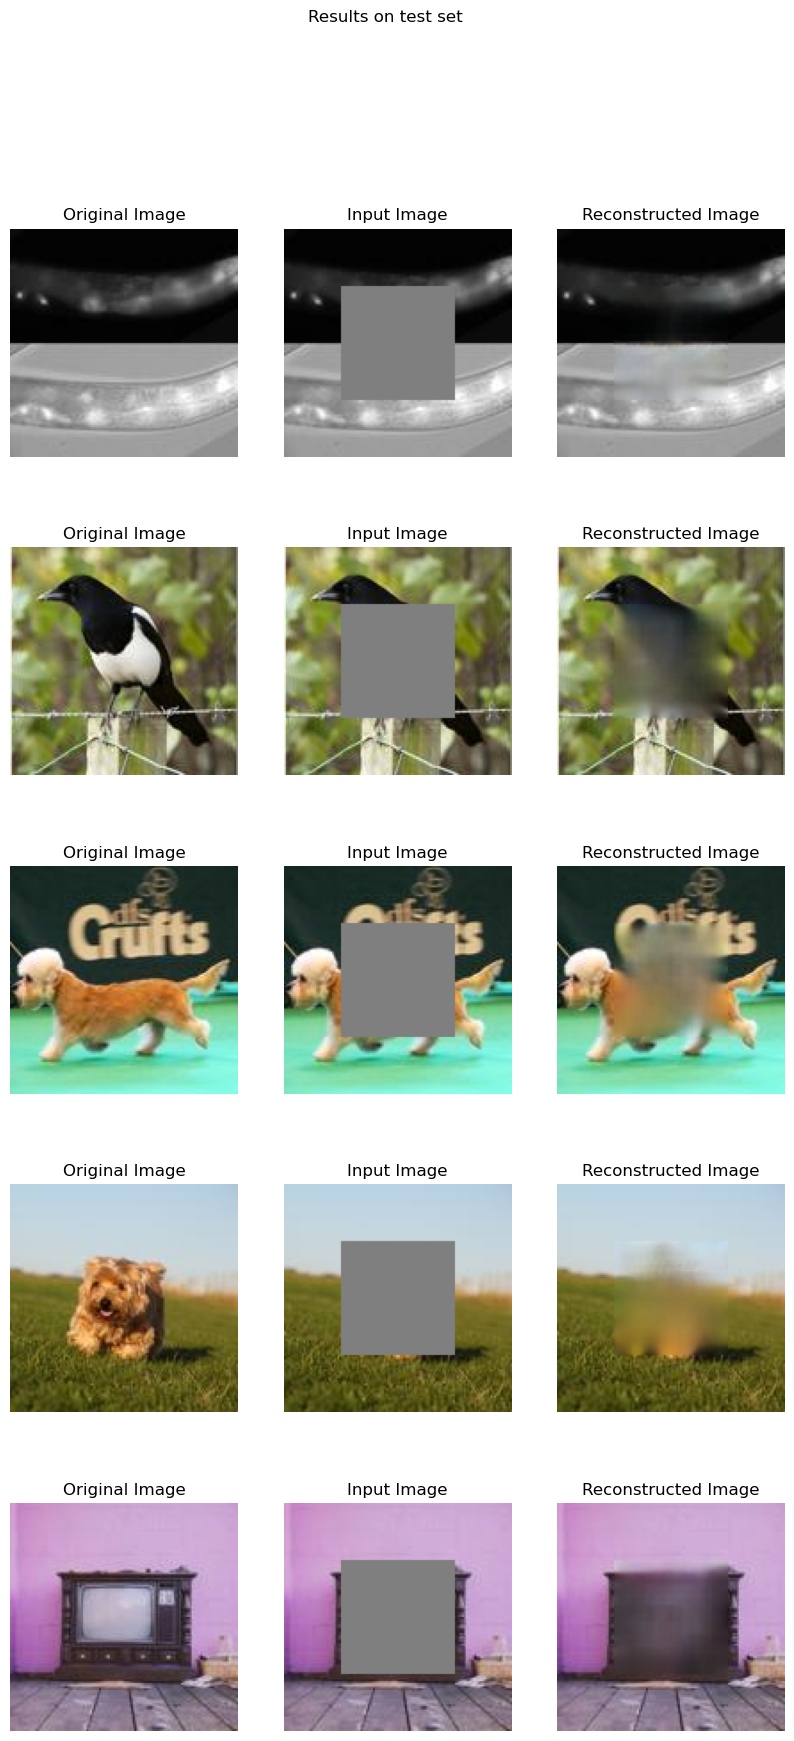

In [8]:
dm.setup("test") # in case "test" wasn't called before this cell

x, y = next(iter(dm.test_dataloader()))
x = x.to(model.device)
y = y.to(model.device)

out = model.forward(x)

print_results_images(x, y, out, "Results on test set", dm.inverse_transform)

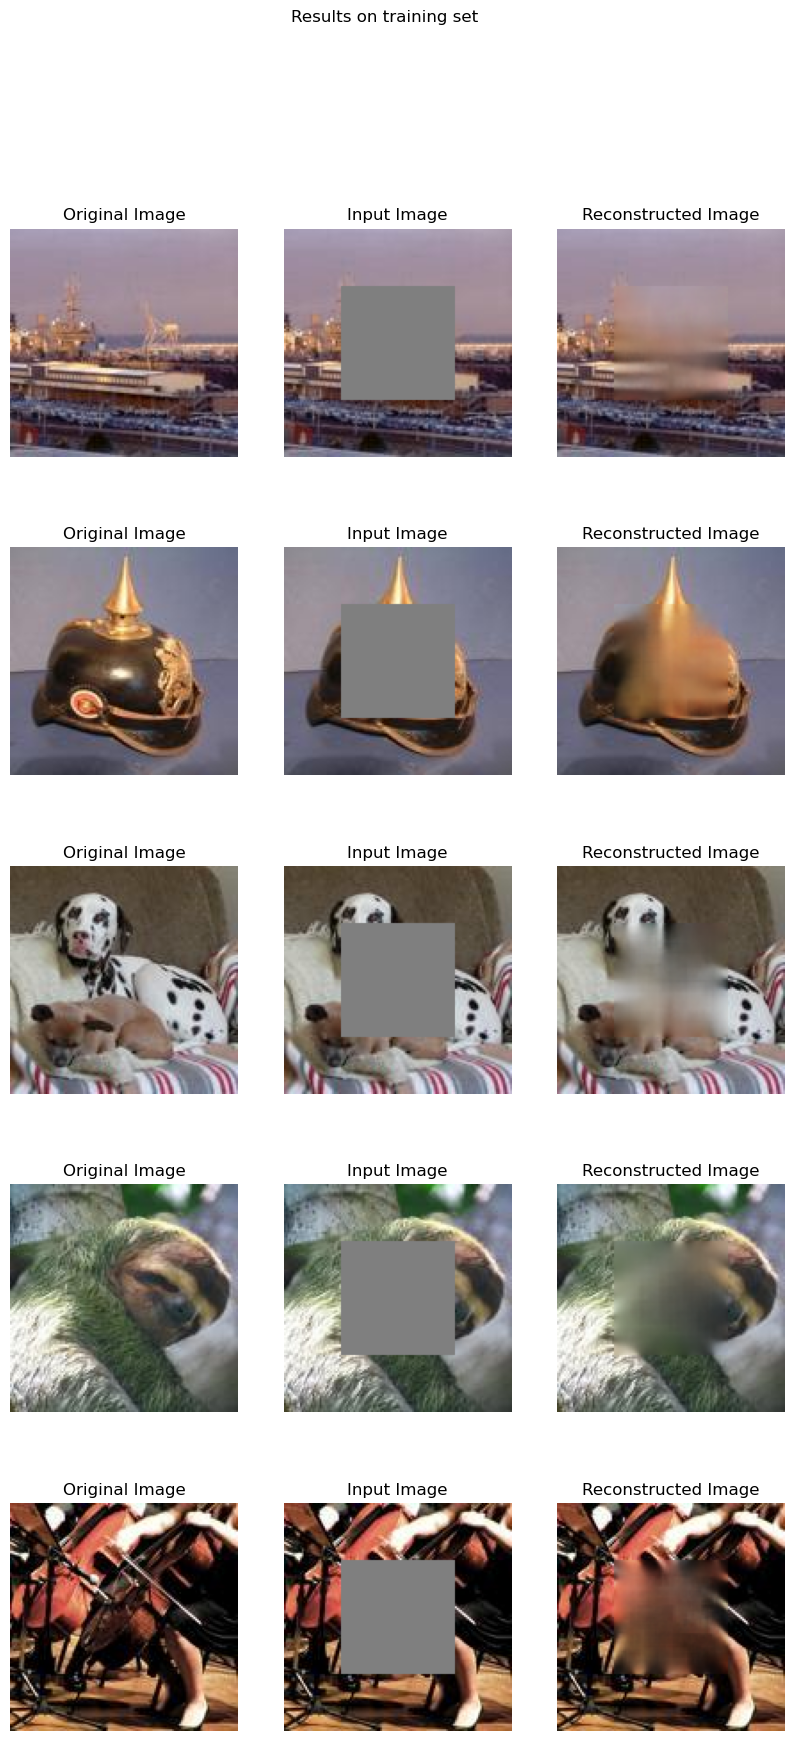

In [9]:
dm.setup("fit") # in case "fit" wasn't called before this cell

x, y = next(iter(dm.train_dataloader()))
x = x.to(model.device)
y = y.to(model.device)
out = model.forward(x)

print_results_images(x, y, out, "Results on training set", dm.inverse_transform)

The last epoch is the one with the best validation loss here